In [1]:
# ref: https://github.com/benja-wu/CozmoGestureRegonize

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="{}".format(1) # gpu idx

In [4]:
import warnings
warnings.simplefilter('ignore')

In [24]:
import socket
hostname = socket.gethostname()
print(hostname)

spacegray


In [6]:
import pandas as pd
import csv
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from models import ModelLoader
from data import CNN3DDataLoader
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import time
print(tf.__version__)

np.random.seed(4)

2.3.0


### Training parameters

In [7]:
n_epochs = 50
batch_size = 4

with open('data_extracted/train.csv', 'r') as train:
    train_files = csv.reader(train)
    cnt_train = 0
    for line in train_files:
        cnt_train += 1
    
with open('data_extracted/validation.csv', 'r') as validation:
    validation_files = csv.reader(validation)
    cnt_validation = 0
    for line in validation_files:
        cnt_validation += 1
    
print("# of training samples:", cnt_train)
print("# of validation samples:", cnt_validation)

# of training samples: 416
# of validation samples: 180


### Data parameters

In [8]:
# specify labels to be trained
#labels_want = ['A004', 'A005', 'A011', 'A016', 'A020', 'A027', 'A031', 'A039', 'A048', 'A052', 'A054', 'A055']

# or "None" for all labels
labels_want = None

In [9]:
data_dir = './data_extracted/'
seq_length = 100
samples_train_per_class = None
samples_val_per_class = None

if labels_want == None:
    n_classes = 12
else:
    n_classes = len(labels_want)

if samples_train_per_class == None:
    n_videos = {'train': cnt_train, 'validation': cnt_validation}
else:
    n_videos = {'train': samples_train_per_class * n_classes, 'validation': samples_val_per_class * n_classes}


image_size=(128, 128)

In [10]:
if labels_want == None:
    print(n_classes)
else:
    print(len(labels_want))
print(n_videos['train'])
print(n_videos['validation'])

12
416
180


In [11]:
if samples_train_per_class == None:
    steps_per_epoch = cnt_train // batch_size
    validation_steps = cnt_validation // batch_size
else:
    steps_per_epoch = samples_train_per_class * n_classes // batch_size
    validation_steps = samples_val_per_class * n_classes // batch_size    

print(steps_per_epoch)
print(validation_steps)

model_name = 'small_c3d'
to_Train = True# False

104
45


### Data load

In [12]:
outDir = './output/{}_CL{}_train{}_val{}/'.format(model_name, n_classes, n_videos['train'], n_videos['validation'])
if not os.path.exists(outDir):
    os.makedirs(outDir)

In [13]:
data = CNN3DDataLoader(data_dir, seq_length=seq_length, n_videos=n_videos, labels = labels_want)
train_gen = data.sequence_generator('train', batch_size, image_size)
validation_gen = data.sequence_generator('validation', batch_size, image_size)

### Training

In [14]:
lr=0.0001
#optimizer = keras.optimizers.Adadelta()
#optimizer = Adam(lr=lr)
optimizer = RMSprop(lr=lr, rho=0.9, epsilon=1e-8)
ml = ModelLoader(data.n_labels, data.seq_length, model_name, image_size=image_size, optimizer = optimizer)
model = ml.model

Loading Small C3D model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 100, 128, 128, 32) 2624      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 100, 64, 64, 32)   0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 100, 64, 64, 64)   55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 50, 32, 32, 64)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 50, 32, 32, 128)   221312    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 25, 16, 16, 128)   0         
_________________________________________________________________
conv3d_3 (Conv3D)            (No

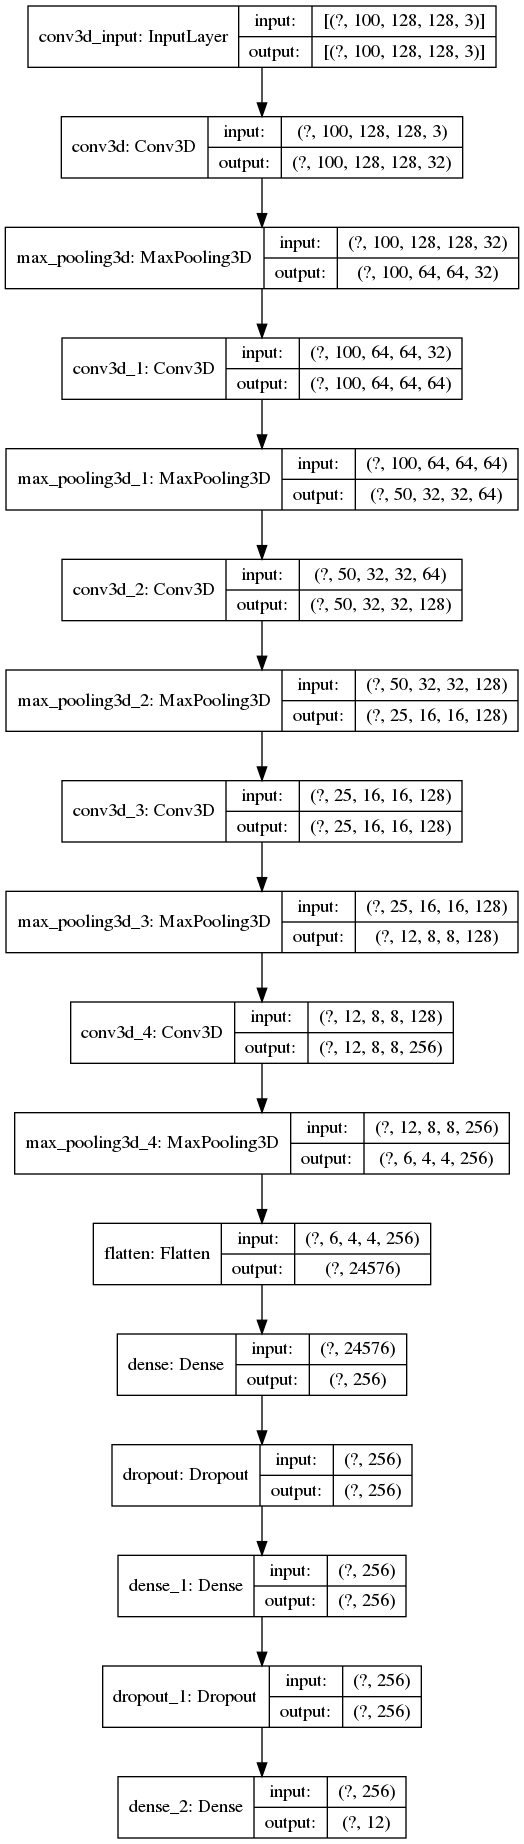

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file=outDir+'model_{}.png'.format(model_name), show_shapes=True)
from IPython.display import Image
Image(outDir+'model_{}.png'.format(model_name))

In [16]:
fn_model = outDir + 'model_{}.h5'.format(model_name)
print(fn_model)

./output/small_c3d_CL12_train416_val180/model_small_c3d.h5


In [17]:
if not to_Train:
    if not os.path.isfile(fn_model):
        to_Train = True
        print('Model file {} not exists !!'.format(fn_model))
        print('Setting to_Train --> {}'.format(to_Train))

    else:
        print('Model file Okay : {}  !!'.format(fn_model))

In [18]:
checkpoint = ModelCheckpoint(outDir + 'ep{epoch:03d}_val_acc{val_acc:.3f}.h5', monitor='val_accuracy', save_weights_only=False, save_best_only=True, save_freq=1)#, period=1

In [19]:
if to_Train:
    history = model.fit_generator(
        generator=train_gen,
        steps_per_epoch=steps_per_epoch,
        #sample_per_epoch= 16,
        epochs=n_epochs,
        verbose=1,
        validation_data=validation_gen,
        validation_steps=validation_steps#,
        #callbacks=[checkpoint]
    )
    model.save(fn_model)
    print("Saved the trained model {}.. okay".format(fn_model))
else:
    model = load_model(fn_model)
    print('Loaded a model {}.. okay'.format(fn_model))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
104/104 [==============================] - 54s 518ms/step - loss: 2.4719 - accuracy: 0.1346 - top_k_categorical_accuracy: 0.4976 - val_loss: 2.2967 - val_accuracy: 0.1944 - val_top_k_categorical_accuracy: 0.5389
Epoch 2/50
104/104 [==============================] - 54s 517ms/step - loss: 1.9390 - accuracy: 0.3365 - top_k_categorical_accuracy: 0.8029 - val_loss: 1.7248 - val_accuracy: 0.3556 - val_top_k_categorical_accuracy: 0.9056
Epoch 3/50
104/104 [==============================] - 54s 515ms/step - loss: 1.4228 - accuracy: 0.5168 - top_k_categorical_accuracy: 0.9423 - val_loss: 1.0756 - val_accuracy: 0.5556 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/50
104/104 [==============================] - 54s 515ms/step - loss: 1.1684 - accuracy: 0.5962 - top_k_categorical_accuracy: 0.9688 - val_loss: 0.6441 - val_accuracy: 0.7500 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/50
104/104 [============

104/104 [==============================] - 54s 517ms/step - loss: 0.0320 - accuracy: 0.9952 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.9842 - val_accuracy: 0.8667 - val_top_k_categorical_accuracy: 1.0000
Epoch 36/50
104/104 [==============================] - 54s 517ms/step - loss: 0.0163 - accuracy: 0.9952 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.7113 - val_accuracy: 0.8833 - val_top_k_categorical_accuracy: 1.0000
Epoch 37/50
104/104 [==============================] - 54s 517ms/step - loss: 0.0271 - accuracy: 0.9928 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.7560 - val_accuracy: 0.9000 - val_top_k_categorical_accuracy: 1.0000
Epoch 38/50
104/104 [==============================] - 54s 517ms/step - loss: 0.0069 - accuracy: 0.9976 - top_k_categorical_accuracy: 1.0000 - val_loss: 1.2861 - val_accuracy: 0.8778 - val_top_k_categorical_accuracy: 1.0000
Epoch 39/50
104/104 [==============================] - 54s 515ms/step - loss: 0.0251 - accuracy: 0.9976 - top_k_cate

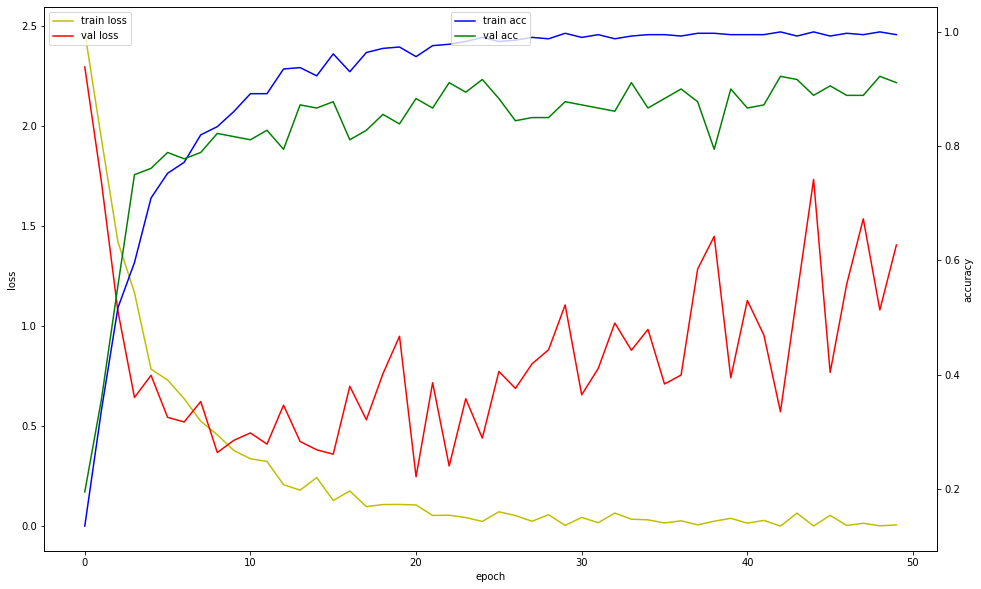

In [20]:
if to_Train:
    fig, loss_ax = plt.subplots(figsize=(16,10))
    acc_ax = loss_ax.twinx()

    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc='upper left')

    acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper center')
    plt.show()

### Validation

In [21]:
model_name = outDir + 'model_small_c3d.h5'
print(model_name)
model = load_model(model_name)

./output/small_c3d_CL12_train416_val180/model_small_c3d.h5


In [22]:
v2 = model.evaluate_generator(generator=validation_gen, steps=validation_steps, verbose=1)
print(v2)

Instructions for updating:
Please use Model.evaluate, which supports generators.
45/45 [==============================] - 16s 353ms/step - loss: 1.1649 - accuracy: 0.9000 - top_k_categorical_accuracy: 1.0000
[1.1649365425109863, 0.8999999761581421, 1.0]


In [23]:
eval_acc2 = v2[1]
print(eval_acc2)

0.8999999761581421
